<a href="https://colab.research.google.com/github/har1s3538/Plant-Disease-Classification-Vision-Transformer/blob/main/notebooks/Plant_Disease_Classification_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Plant Disease Classification using Vision Transformers
# Domain: Agriculture
# Dataset: PlantVillage (color images)
# Author: <Your Name>


In [4]:
# Notebook Structure:
# 1. Environment Setup
# 2. Dataset Download (Kaggle)
# 3. Data Preprocessing
# 4. Baseline CNN Model
# 5. Vision Transformer Model
# 6. Training and Evaluation
# 7. Results and Visualization


In [5]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_1d44a7655416c1c215f55b1fe3a4cb6a"


In [6]:
!curl -L \
  -H "Authorization: Bearer $KAGGLE_API_TOKEN" \
  https://www.kaggle.com/api/v1/datasets/download/abdallahalidev/plantvillage-dataset \
  -o plantvillage-dataset.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2087M  100 2087M    0     0  86.5M      0  0:00:24  0:00:24 --:--:--  153M


In [7]:
!unzip plantvillage-dataset.zip



Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [8]:
!ls "plantvillage dataset"


color  grayscale  segmented


In [9]:
!ls "plantvillage dataset/color" | head


Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry_(including_sour)___healthy
Cherry_(including_sour)___Powdery_mildew
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___healthy


In [10]:
!ls "plantvillage dataset/color" | wc -l


38


In [11]:
!find "plantvillage dataset/color" -type f | wc -l


54305


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

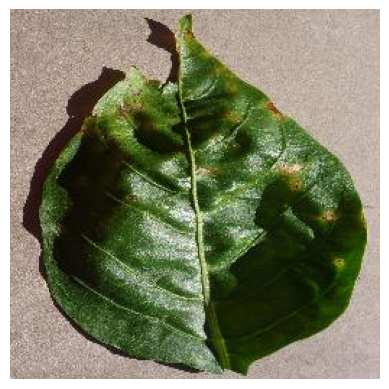

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import os

root = "plantvillage dataset/color"
class_name = os.listdir(root)[0]
img_path = os.path.join(root, class_name, os.listdir(os.path.join(root, class_name))[0])

img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")


In [13]:
import os

DATASET_DIR = "plantvillage dataset/color"

print("Number of classes:", len(os.listdir(DATASET_DIR)))
print("Sample classes:", os.listdir(DATASET_DIR)[:5])


Number of classes: 38
Sample classes: ['Pepper,_bell___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___healthy', 'Peach___Bacterial_spot']


In [14]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 54305 files belonging to 38 classes.
Using 38014 files for training.
Found 54305 files belonging to 38 classes.
Using 16291 files for validation.


In [15]:
val_size = int(0.5 * temp_ds.cardinality().numpy())

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

print("Train batches:", train_ds.cardinality().numpy())
print("Validation batches:", val_ds.cardinality().numpy())
print("Test batches:", test_ds.cardinality().numpy())


Train batches: 1188
Validation batches: 255
Test batches: 255


In [16]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [17]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [18]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

augmented_train_ds = augmented_train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [20]:
for images, labels in train_ds.take(1):
    print("dtype:", images.dtype)
    print("min value:", tf.reduce_min(images).numpy())
    print("max value:", tf.reduce_max(images).numpy())


dtype: <dtype: 'float32'>
min value: 0.0
max value: 254.15819


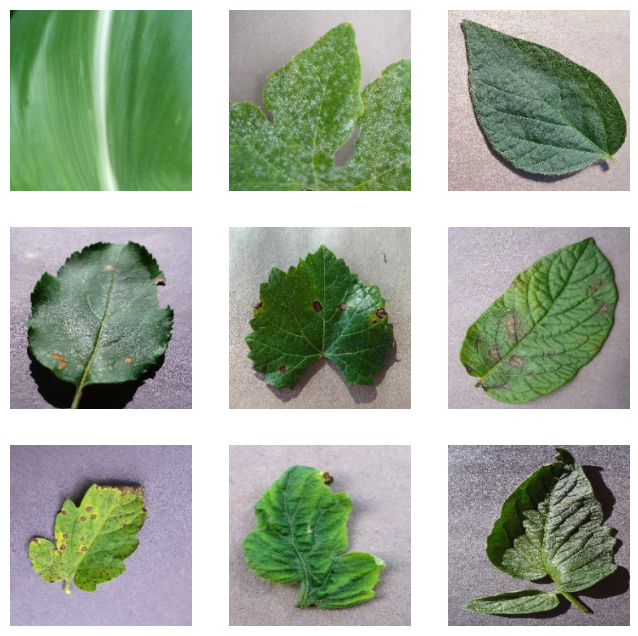

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf

for images, labels in train_ds.take(1):
    plt.figure(figsize=(8, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        img = images[i]

        # SAFE normalization for visualization only
        img = tf.cast(img, tf.float32)
        img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-7)

        plt.imshow(img)
        plt.axis("off")
    plt.show()


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

NUM_CLASSES = 38  # confirmed from dataset

def build_cnn_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        # Normalization INSIDE model (best practice)
        layers.Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [23]:
cnn_model = build_cnn_model()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,793,382 (98.39 MB)

 Trainable params: 25,793,382 (98.39 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
EPOCHS = 10  # baseline training

history_cnn = cnn_model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 472s 391ms/step - accuracy: 0.3378 - loss: 2.5304 - val_accuracy: 0.7170 - val_loss: 0.9137
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 349s 293ms/step - accuracy: 0.6400 - loss: 1.2132 - val_accuracy: 0.7963 - val_loss: 0.6481
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 348s 293ms/step - accuracy: 0.7298 - loss: 0.8950 - val_accuracy: 0.8277 - val_loss: 0.5521
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 353s 297ms/step - accuracy: 0.7774 - loss: 0.7368 - val_accuracy: 0.8749 - val_loss: 0.3924
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 348s 292ms/step - accuracy: 0.8003 - loss: 0.6400 - val_accuracy: 0.8968 - val_loss: 0.3111
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 348s 293ms/step - accuracy: 0.8247 - loss: 0.5682 - val_accuracy: 0.9058 - val_loss: 0.2842
Epoch 7/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 352s 296ms/step - accuracy: 0.8408 - loss: 0.5141 - val_accuracy: 0.8957 - val_loss: 0.3223
Epoch 8/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 349s 293ms/step - ac

In [25]:
import os
os.makedirs("results", exist_ok=True)


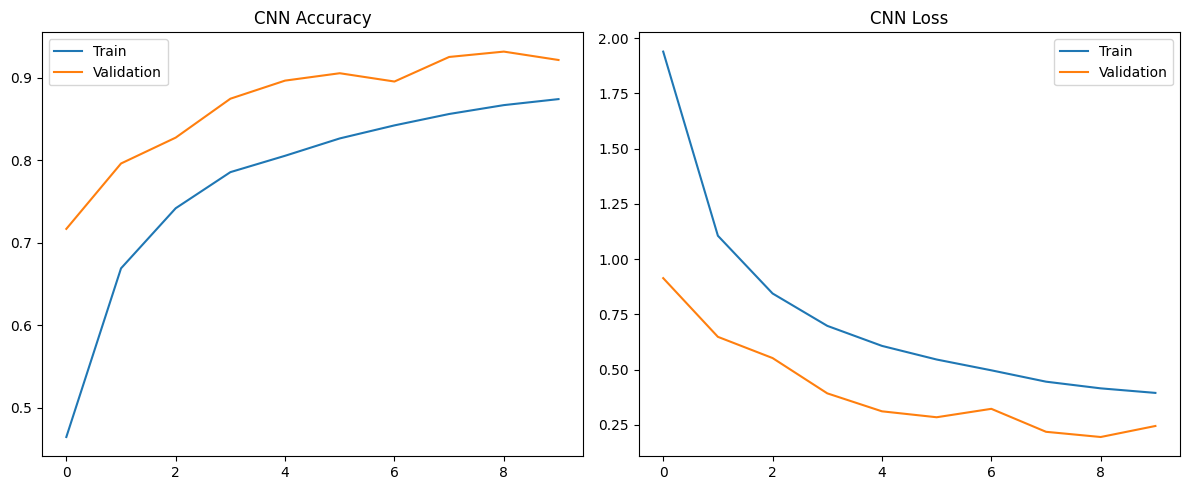

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.title('CNN Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title('CNN Loss')
plt.legend()

plt.tight_layout()
plt.savefig("results/cnn_accuracy_loss.png")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━

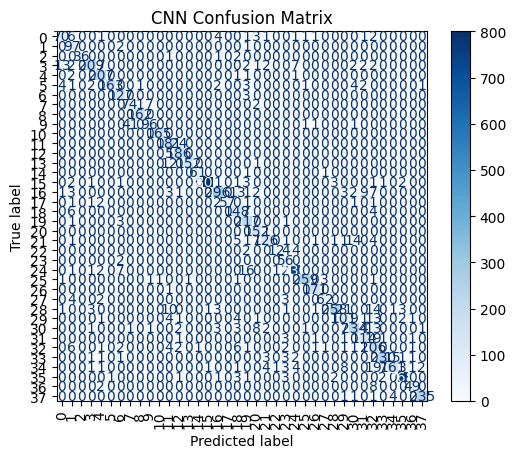

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

for images, labels in test_ds:
    preds = cnn_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.savefig("results/cnn_confusion_matrix.png")
plt.show()


In [28]:
import tensorflow as tf
from tensorflow.keras import layers


In [29]:
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = layers.Dense(embed_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return self.projection(patches)


In [30]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm2 = layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.dropout = layers.Dropout(dropout)

    def call(self, x, training=False):
        attn_out = self.attn(self.norm1(x), self.norm1(x))
        x = x + attn_out
        mlp_out = self.mlp(self.norm2(x))
        return x + self.dropout(mlp_out, training=training)


In [31]:
def build_vit_model(
    image_size=224,
    patch_size=16,
    embed_dim=128,
    num_heads=4,
    mlp_dim=256,
    num_layers=6,
    num_classes=38,
):
    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Normalize inside model
    x = layers.Rescaling(1./255)(inputs)

    # Patch embedding
    patches = PatchEmbedding(patch_size, embed_dim)(x)

    # Positional embedding
    num_patches = (image_size // patch_size) ** 2
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(positions)
    x = patches + pos_embed

    # Transformer blocks
    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, num_heads, mlp_dim)(x)

    # Classification head
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)


In [32]:
vit_model = build_vit_model()
vit_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embedding                 │ (None, None, 128)      │        98,432 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 196, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 196, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 196, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 196, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, 196, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_5           │ (None, 196, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 196, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,085,030 (7.95 MB)

 Trainable params: 2,085,030 (7.95 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [35]:
EPOCHS_VIT = 15


In [36]:
history_vit = vit_model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_VIT
)


Epoch 1/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 401s 311ms/step - accuracy: 0.3803 - loss: 2.3301 - val_accuracy: 0.7512 - val_loss: 0.8404
Epoch 2/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 359s 302ms/step - accuracy: 0.7806 - loss: 0.7457 - val_accuracy: 0.8468 - val_loss: 0.5024
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 358s 301ms/step - accuracy: 0.8530 - loss: 0.4868 - val_accuracy: 0.8790 - val_loss: 0.3832
Epoch 4/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 351s 296ms/step - accuracy: 0.8850 - loss: 0.3698 - val_accuracy: 0.8888 - val_loss: 0.3433
Epoch 5/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 481s 379ms/step - accuracy: 0.9035 - loss: 0.3115 - val_accuracy: 0.8828 - val_loss: 0.3449
Epoch 6/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 453s 381ms/step - accuracy: 0.9163 - loss: 0.2642 - val_accuracy: 0.9165 - val_loss: 0.2603
Epoch 7/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 506s 384ms/step - accuracy: 0.9250 - loss: 0.2349 - val_accuracy: 0.9298 - val_loss: 0.2096
Epoch 8/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 363s 305ms/step - ac

In [37]:
vit_test_loss, vit_test_accuracy = vit_model.evaluate(test_ds)
print(f"Test Accuracy (ViT): {vit_test_accuracy:.4f}")


255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9459 - loss: 0.1684
Test Accuracy (ViT): 0.9481


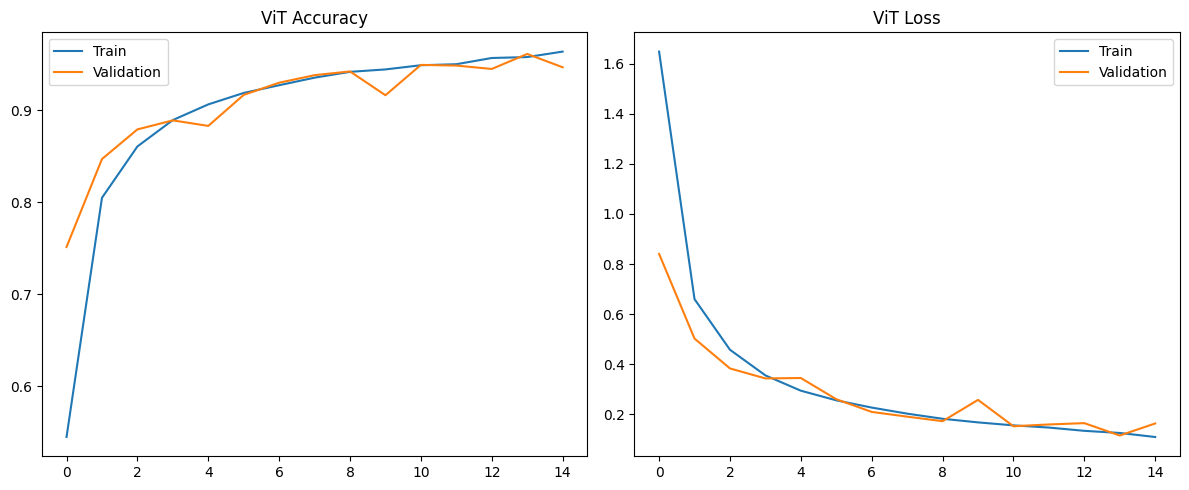

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_vit.history['accuracy'], label='Train')
plt.plot(history_vit.history['val_accuracy'], label='Validation')
plt.title('ViT Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_vit.history['loss'], label='Train')
plt.plot(history_vit.history['val_loss'], label='Validation')
plt.title('ViT Loss')
plt.legend()

plt.tight_layout()
plt.savefig("results/vit_accuracy_loss.png")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━

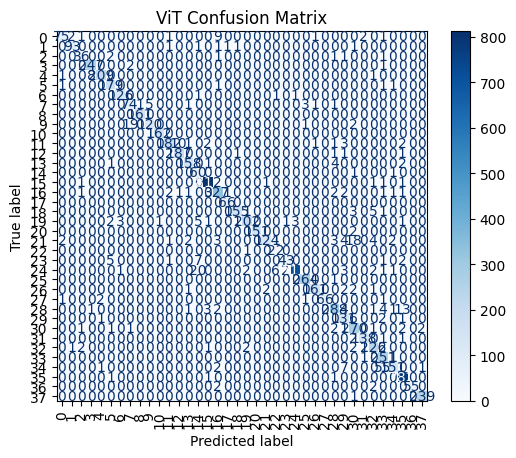

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

for images, labels in test_ds:
    preds = vit_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm_vit = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm_vit)
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("ViT Confusion Matrix")
plt.savefig("results/vit_confusion_matrix.png")
plt.show()
